In [82]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import randn, seed
from scipy.optimize import minimize
import seaborn as sns

In [83]:
%config InlineBackend.figure_format = "retina"

In [84]:
port_path = "Prueba.xlsx"
market = pd.read_excel(port_path, index_col=0)
market.columns = [col.replace(" MF Equity", "").replace(" INDEX","") for col in market.columns]

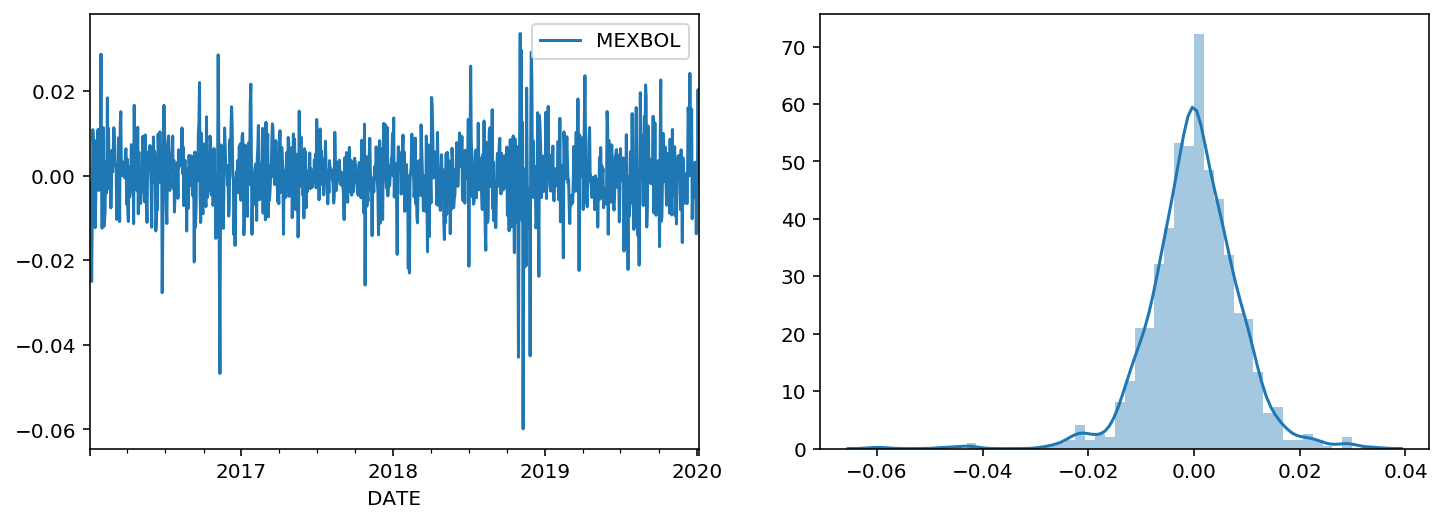

In [85]:
R = market[["MEXBOL"]]
R = np.log(R).diff().dropna()
fig, ax = plt.subplots(1, 2, figsize=(12,4))
R.plot(ax=ax[0]);
sns.distplot(R, ax=ax[1]);

In [86]:
test_year = "2019"
R_train = R[:test_year]
R_test = R[test_year:]

In [87]:
def VolDimSigmas(lamd, sigma_init, R):
    sigma_hist = [sigma_init]
    N, M = R.shape
    for t in range(N - 1, -1, -1):
        rt0 = 0 if t == 0 else R.iloc[t - 1, 0]
        sigma0 = sigma_hist[-1]
        sigma1 = (1 - lamd) * rt0 ** 2 + lamd * sigma0
        sigma_hist.append(sigma1)
    
    return sigma_hist

In [88]:
def VolDim(lamd, sigma_init, R):
    sigma_hista = np.array(VolDimSigmas(lamd, sigma_init, R)[1:])
    r1_2 = R.values.ravel() ** 2
    log_likelihood = (np.log(sigma_hista) + r1_2 / sigma_hista).sum() / 2
    return log_likelihood

In [89]:
seed(314)
lamd = np.abs(randn(1))
sigma_init = R.var(ddof=1).item() / 252
VolDim(lamd, sigma_init, R)

C:\Users\DMUNGUIA\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: `item` has been deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


-551705.0600243221

In [97]:
x0 = np.array([lamd])
L_part = lambda x0: VolDim(*x0, sigma_init, R)

def cons(x):
    return 1 - x[0]

bounds = [
    (0, None)
]

In [98]:
fmin = minimize(L_part, x0,
               constraints = {"type": "ineq", "fun": cons},
               bounds = bounds)

C:\Users\DMUNGUIA\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


In [99]:
fmin

     fun: -4355.826078640734
     jac: array([0.05291748])
 message: 'Optimization terminated successfully.'
    nfev: 38
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([0.90886798])

In [104]:
lamd_opt = fmin.x[0]
sigma0 = sigma_init
voldim_predict = []
for i in range(len(R)):
    sigma0 = (1 - lamd_opt) * R.iloc[i, 0] ** 2 + lamd_opt * sigma0
    voldim_predict.append(sigma0)

In [105]:
%matplotlib inline

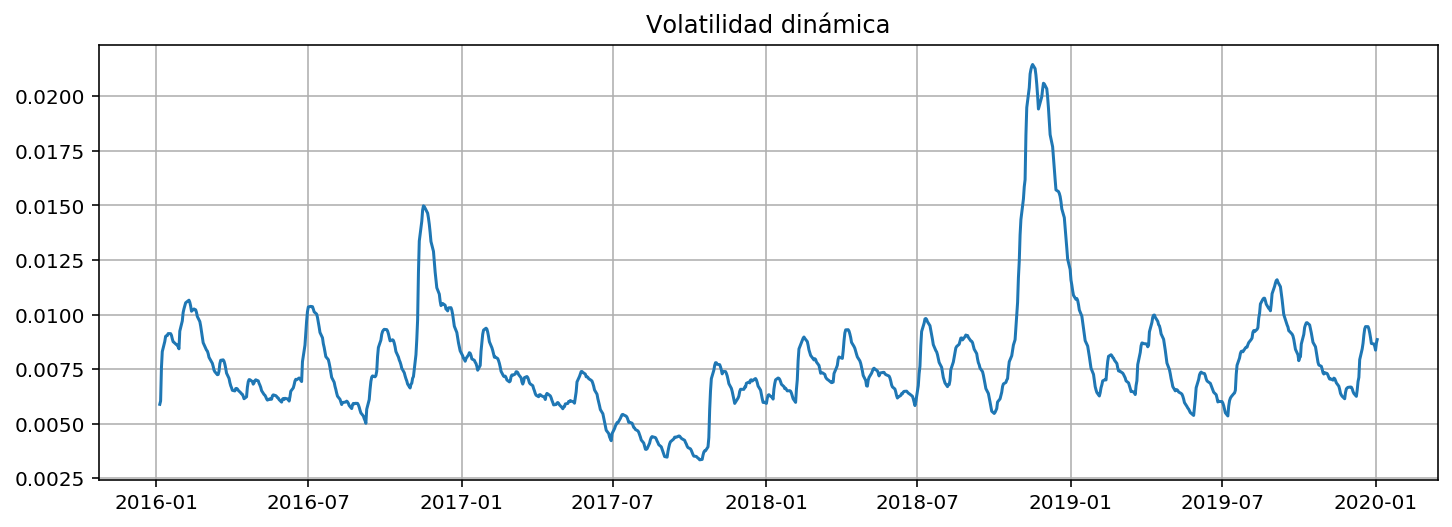

In [106]:
xaxis = R.index[1:]
sigma_voldim = pd.Series(np.sqrt(voldim_predict)[1:])

plt.subplots(figsize = (12, 4))
plt.title("Volatilidad dinámica")
plt.grid()
plt.plot(xaxis, sigma_voldim.ewm(3).mean());